# Lab1 Gradient Descent

# Import and Init Dataset
compile feature normalization first

In [1]:
# Import
import configparser
import distutils.log
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [69]:
# Init data
df = pd.read_csv('D:\\学术资料\\硕士\\NYU\\DS-GA-1003\\Week1\\hw1\\hw1-sgd\\hw1-data.csv', delimiter=',')
X = df.values[:, :-1]
y = df.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))  # Add bias term

# Feature Normalization
only operate train dataset.
shift all data to ensure they are all larger than 0, then rescale them into [0,1]  
$X_{norm}=\frac{X-X{min}}{X_{max}\ \ \ \ -\ X_{min}}$
## Wanrning  
数据标准化必须以特征列为单位。不能所有数据共同标准化。因为不同feature的数据尺度不同。

In [68]:
def feature_normalization(train: np.ndarray, test: np.ndarray) -> [np.ndarray, np.ndarray]:
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test  - test set, a 2D numpy array of size (num_instances, num_features)
    Returns:
        train_normalized - training set after normalization
        test_normalized  - test set after normalization

    """
    min_value: np.ndarray = np.min(train, axis=0)
    max_value: np.ndarray = np.max(train, axis=0)

    for index in range(len(max_value)):
        if min_value[index] == max_value[index]:
            min_value[index] = 0

    train_normalized = (train - min_value) / (max_value - min_value + 0.0)
    test_normalized = (test - min_value) / (max_value - min_value + 0.0)

    return train_normalized, test_normalized


# Linear Regression with Full Batch

## Compute Square Loss
Given a set of X, y, theta, compute the square loss for predicting y with X*theta   
loss func: $J(\theta)=\frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x_i)-y_i)^2$  
In matrix formulation, $h_{\theta}(x_i)=\theta ^{T}x_i$  
So $J(\theta)=\frac{1}{2m}(X\theta^{T}-y)(X\theta^{T}-y)^{T}$  


In [5]:
def compute_square_loss(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> float:
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)

    Returns:
        loss - the square loss, scalar
    """

    num_instances = X.shape[0]
    auction = np.dot(X, theta)
    difference: np.ndarray = auction - y

    loss: float = 0.5 / num_instances * np.dot(difference, difference)
    return loss

## Compute Square Loss Gradient
$J(\theta)=\frac{1}{2m}(X\theta^{T}-y)(X\theta^{T}-y)^{T}$   
$\bigtriangledown\theta J(\theta)=\frac{1}{m}(X\theta^{T}-y)X$

In [74]:
def compute_square_loss_gradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Compute gradient of the square loss (as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """

    num_instances = X.shape[0]
    difference: np.ndarray = np.dot(X, theta) - y
    grad = 1.0 / (num_instances+0.0) * np.dot(difference.T, X)
    return grad

## Gradient Check
Check that the function compute_square_loss_gradient returns the correct gradient for the given X, y, and theta.  
For all directions: let $e_1 = (1,0,0,\dots,0), e_2 = (0,1,0,\dots,0), \dots, e_d = (0,\dots,0,1)$  
Use approximation: $\frac{J(\theta + epsilon * e_i) - J(\theta - epsilon * e_i)}{(2*epsilon)}$ for each direction  
Then for each direction of gradient, check if Euclidean distance of approximation and computed is exceed tolerance(1e-4 default)  

In [7]:
def grad_checker(X: np.ndarray, y: np.ndarray, theta: np.ndarray, epsilon=0.01, tolerance=1e-4) -> bool:
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1)

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicate whether the gradient is correct or not

    """
    true_gradient: np.ndarray = compute_square_loss_gradient(X, y, theta)  # the true gradient
    num_features = theta.shape[0]
    approx_grad: np.ndarray = np.zeros(num_features)  # Initialize the gradient we approximate
    # TODO
    for index in range(num_features):
        e_i = np.zeros(num_features)
        e_i[index] = 1
        theta_plus = theta + epsilon * e_i
        theta_minus = theta - epsilon * e_i
        approx_grad[index] = \
            (compute_square_loss(X, y, theta_plus) - compute_square_loss(X, y, theta_minus)) \
            / (2 * epsilon)
    distance = np.linalg.norm(approx_grad-true_gradient)
    return distance < tolerance

## Generic Gradient Checker
Similar as Gradient Checker
The functions takes objective_func and gradient_func as parameters. And check whether gradient_func(X, y, theta) returned  
the true gradient for objective_func(X, y, theta).  
Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient  

In [8]:
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. And check whether gradient_func(X, y, theta) returned
    the true gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    true_gradient: np.ndarray = gradient_func(X, y, theta)  # the true gradient
    num_features = theta.shape[0]
    approx_grad: np.ndarray = np.zeros(num_features)  # Initialize the gradient we approximate

    for index in range(num_features):
        e_i = np.zeros(num_features)
        e_i[index] = 1
        theta_plus = theta + epsilon * e_i
        theta_minus = theta - epsilon * e_i
        approx_grad[index] = \
            (objective_func(X, y, theta_plus) - objective_func(X, y, theta_minus)) \
            / (2 * epsilon)
    distance = np.linalg.norm(approx_grad - true_gradient)
    return distance < tolerance

## Batch Grad Descent  
每次迭代计算梯度，然后$\theta$下降一次梯度

In [9]:
def batch_grad_descent(X: np.ndarray, y: np.ndarray, step_size=0.1, num_iter=1000, check_gradient=False) \
        -> [np.ndarray, np.ndarray]:
    """
    In this question you will implement batch gradient descent to
    minimize the square loss objective

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        step - step size in gradient descent
        num_iter - number of iterations to run
        check_gradient - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - store the history of parameter vector in iteration, 2D numpy array of size (num_iter+1, num_features)
                    for instance, theta in iteration 0 should be theta_hist[0], theta in iteration (num_iter) is theta_hist[-1]
        loss_hist - the history of objective function vector, 1D numpy array of size (num_iter+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter + 1, num_features))  # Initialize theta_hist
    loss_hist = np.zeros(num_iter + 1)  # initialize loss_hist
    theta = np.ones(num_features)  # initialize theta
    # TODO
    theta_hist[0] = theta
    loss_hist[0] = compute_square_loss(X, y, theta)

    for iteration in range(1, num_iter + 1):
        if check_gradient:
            assert (grad_checker(X, y, theta) is True)
        grad = compute_square_loss_gradient(X, y, theta)
        theta = theta - step_size*grad.transpose()
        theta_hist[iteration] = theta
        loss = compute_square_loss(X, y, theta.transpose())
        loss_hist[iteration] = loss

    return theta_hist, loss_hist

## Draw Convergence Diagram
Try step sizes [0.01, 0.05, 0.1, 0.101, 0.2]. Plot the value of the objective function as a function of the number of steps for each step sizes. Briefly summarize your findings.
### Note
If step size is too small, it will converge will slow. If step size is too large, it will oscillate and therefore, never converge.

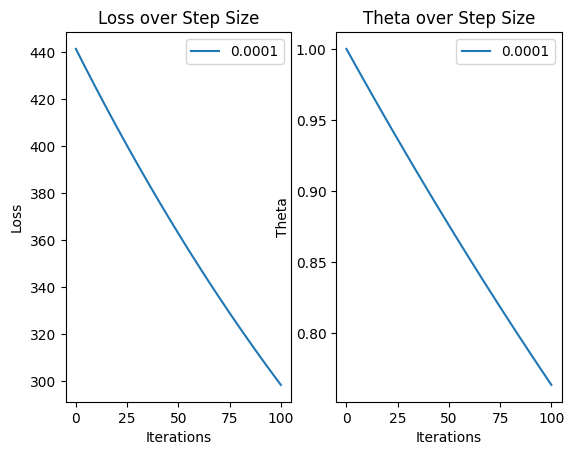

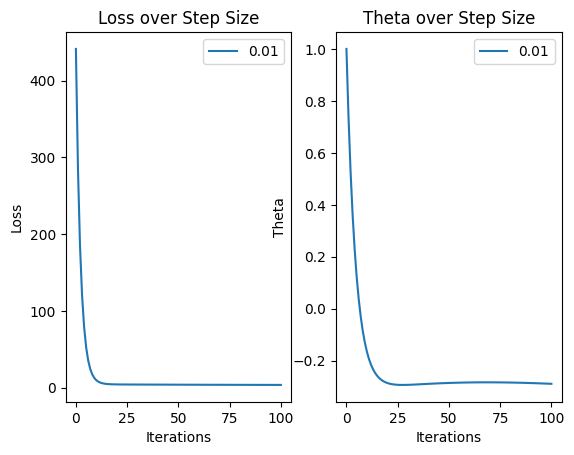

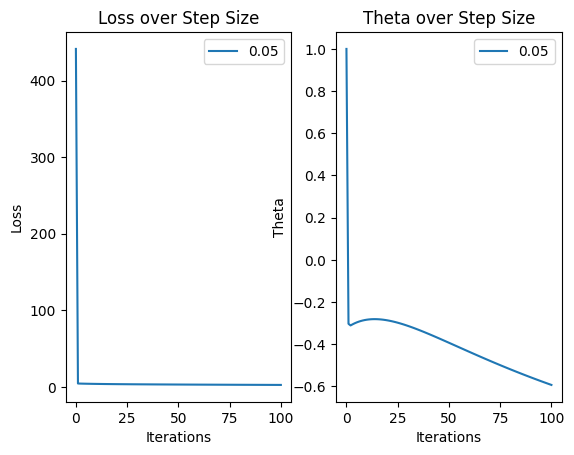

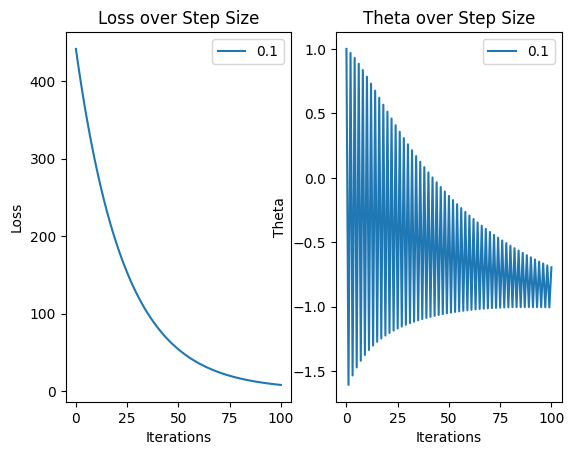

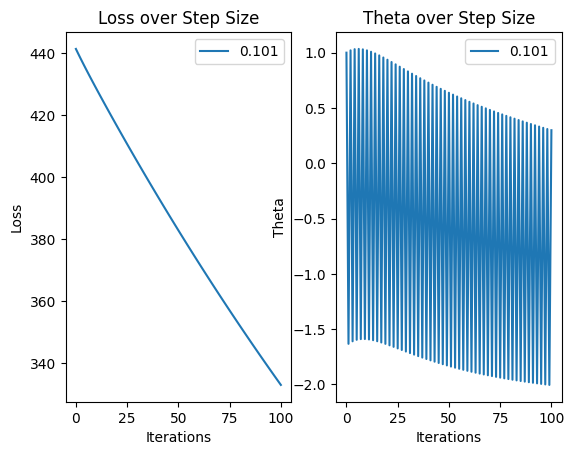

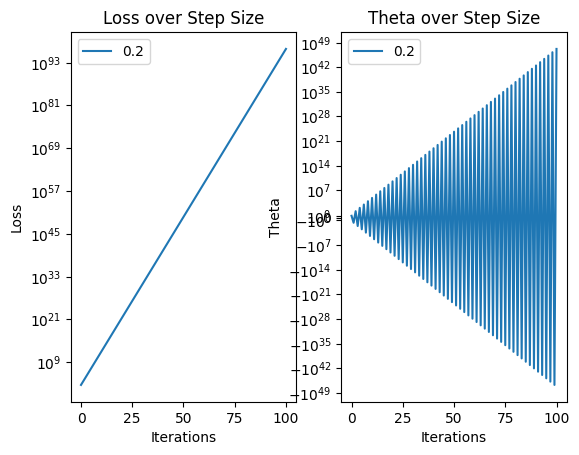

In [71]:
def draw(theta_hist, loss_hist, step_size, num_iter):
    x_index = []
    for i in range(num_iter + 1):
        x_index.append(i)
    plt.subplot(1, 2, 1)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss over Step Size')
    if loss_hist[-1] > 1000:
        plt.yscale('log')
    plt.plot(x_index, loss_hist, label=step_size)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x_index, theta_hist.transpose()[0], label=step_size)
    plt.xlabel('Iterations')
    plt.ylabel('Theta')
    plt.title('Theta over Step Size')
    if theta_hist.transpose()[0][-1] > 100:
        plt.yscale('symlog')
    plt.legend()
    plt.show()


def converge_test(X, y, num_iter=100):
    step_sizes = np.array([0.0001, 0.01, 0.05, 0.1, 0.101, 0.2])
    x_index = []
    for i in range(num_iter + 1):
        x_index.append(i)

    for step_size in step_sizes:
        theta_hist, loss_hist = batch_grad_descent(X, y,
                                                   step_size=step_size,
                                                   num_iter=num_iter,
                                                   check_gradient=False)
        draw(theta_hist, loss_hist, step_size, num_iter)

        
converge_test(X_train, y_train)

# Ridge Regression with L2 Regularized

## Compute Regularized Square Loss Gradient
In Ridge Regression
Given a set of X, y, theta, compute the square loss for predicting y with X*theta   
loss func: $J(\theta)=\frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x_i)-y_i)^2+\lambda \theta^{T}\theta$  
In matrix formulation, $h_{\theta}(x_i)=\theta ^{T}x_i$  
So $J(\theta)=\frac{1}{2m}(X\theta^{T}-y)(X\theta^{T}-y)^{T}+\lambda \theta^{T}\theta$  
$\bigtriangledown J(\theta)=\frac{1}{m}(x\theta -y)^{T}x+2\lambda \theta^{T}$

In [42]:
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    # TODO
    square_loss_gradient = compute_square_loss_gradient(X, y, theta)
    return square_loss_gradient + 2*lambda_reg*theta.T

## Regularized Grad Descent
same as line regression, except use regularized squre loss function

In [46]:
def regularized_grad_descent(X, y, step_size=0.05, lambda_reg=1, num_iter=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        numIter - number of iterations to run

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size (num_iter+1, num_features)
        loss_hist - the history of regularized loss value, 1D numpy array
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter + 1, num_features))  # Initialize theta_hist
    loss_hist = np.zeros(num_iter + 1)  # initialize loss_hist
    theta = np.ones(num_features)  # initialize theta
    theta_hist[0] = theta
    loss_hist[0] = compute_square_loss(X, y, theta)

    for iteration in range(1, num_iter + 1):
        grad = compute_regularized_square_loss_gradient(X, y, theta, lambda_reg)
        theta = theta - step_size * grad.T
        theta_hist[iteration] = theta
        loss_hist[iteration] = compute_square_loss(X, y, theta)

    return theta_hist, loss_hist


## Visualize Ridge Regression

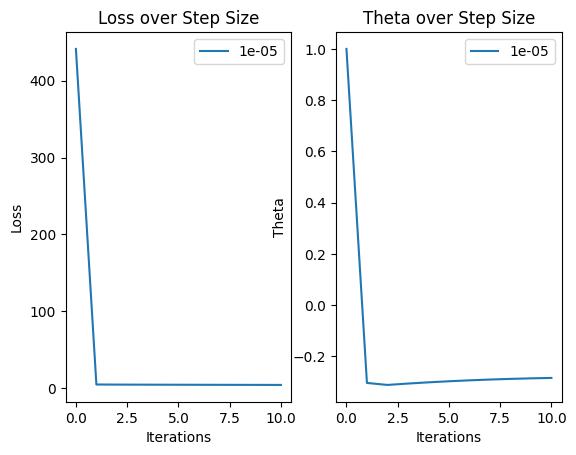

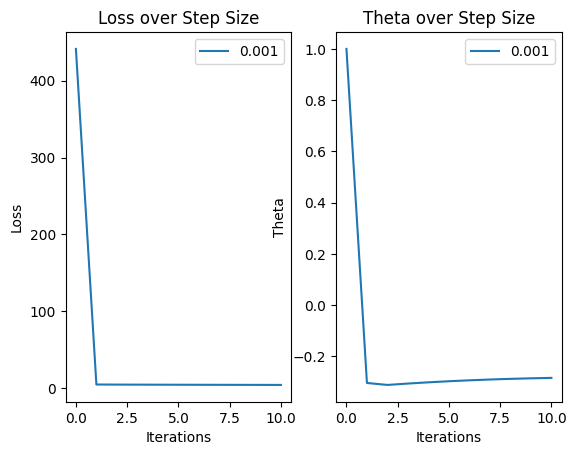

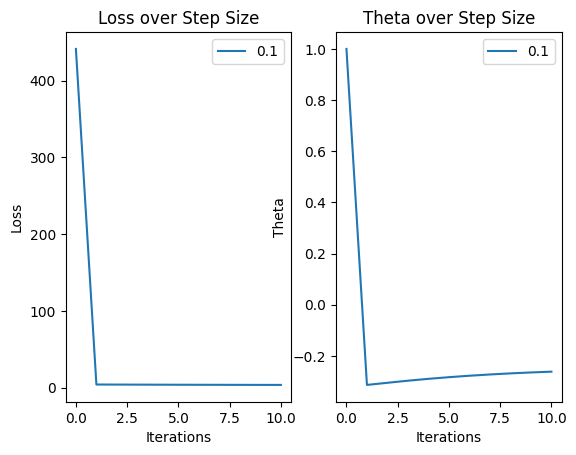

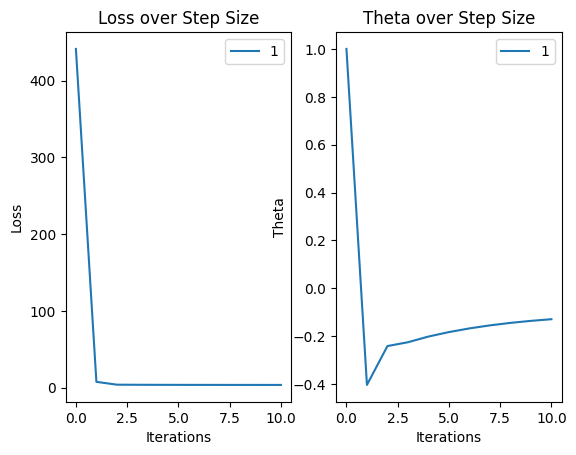

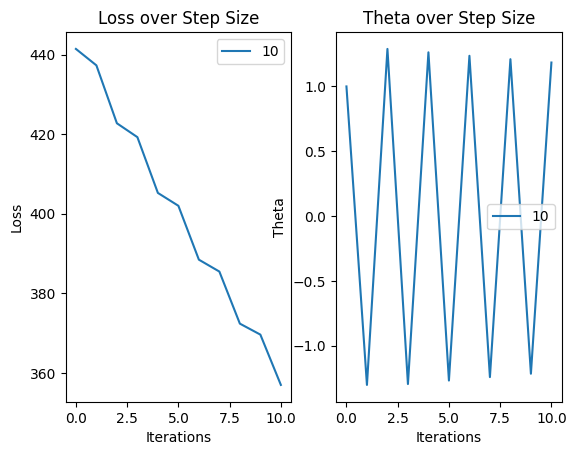

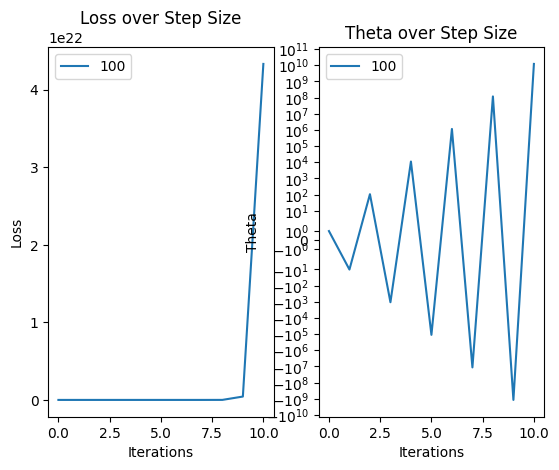

In [49]:
def visualize_regularized_batch_gradient_descent(X, y):
    num_iter = 10
    for lambda_reg in [1e-5, 1e-3, 1e-1, 1, 10, 100]:
        theta_hist, loss_hist = regularized_grad_descent(X, y, lambda_reg = lambda_reg, num_iter=num_iter)
        draw(theta_hist, loss_hist, lambda_reg, num_iter)
        
visualize_regularized_batch_gradient_descent(X_train, y_train)

# Stochastic Grad Descent(SGD)
If dataset is too large, compute loss gradient for the whole dataset is time-comsuming.  
So we can divide a dataset into many batch, i.e. minibatch  
**Epoch**: if you run some minibatch that coverge the dataset, then you run 1 epoch  
The batch size of the code is 50% of whole dataset.   
The epoch is 100  

## 4 step size methods:
if step_size is a float, then the step size in every iteration is constant.  
if step_size == "1/sqrt(t)", $step\ size = \frac{1}{\sqrt{t}}$  
if step_size == "1/t", $StepSize= \frac{1}{t}$  
if step_size == "frac", $StepSize=\frac{StepSize_{0}}{1+StepSize_{0}*lambda*t}$, whereas $StepSize_{0}$ is set up bu you

In [66]:
def stochastic_grad_descent(X, y, step_size=0.1, lambda_reg: float = 1, num_iter=100) -> [np.ndarray, np.ndarray]:
    """
    In this question you will implement stochastic gradient descent with a regularization term

    Args:
        :param X - the feature vector, 2D numpy array of size (num_instances, num_features)
        :param y - the label vector, 1D numpy array of size (num_instances)
        :param step_size - string or float. step size in gradient descent
                NOTE: In SGD, it's not always a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if step_size is a float, then the step size in every iteration is alpha.
                if step_size == "1/sqrt(t)", alpha = 1/sqrt(t)
                if step_size == "1/t", alpha = 1/t
                if step_size == "frac", step_size = step_size_0/(1+step_size_0*lambda*t)"
        :param lambda_reg - the regularization coefficient
        :param num_iter - number of epochs (i.e. number of times) to go through the whole training set

    Returns:
        :return theta_hist - the history of parameter vector, 3D numpy array of size (num_iter, num_instances, num_features)
        :return loss hist - the history of regularized loss function vector, 2D numpy array of size(num_iter, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features)  # Initialize theta

    theta_hist = np.zeros((num_iter + 1, num_features))  # Initialize theta_hist
    loss_hist = np.zeros(num_iter + 1)  # Initialize loss_hist
    theta_hist[0] = theta
    loss_hist[0] = compute_square_loss(X, y, theta)
    step_size_0: float = 1.0
    step_size_method = step_size
    if step_size_method == "frac":
        step_size_0: float = 0.1

    for t in range(1, num_iter + 1):
        if step_size_method == "1/sqrt(t)":
            step_size = 1.0 / np.sqrt(t + 1)
        elif step_size_method == "1/t":
            step_size = 1 / (t + 1)
        elif step_size_method == "frac":
            step_size = step_size_0 / (1.0 + step_size_0 * lambda_reg * (t + 1.0))
        else:
            pass

        X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.5, random_state=10)
        X_1, X_2 = feature_normalization(X_1, X_2)
        grad = compute_regularized_square_loss_gradient(X_1, y_1, theta, lambda_reg)
        theta = theta - step_size * grad.T
        grad = compute_regularized_square_loss_gradient(X_2, y_2, theta, lambda_reg)
        theta = theta - step_size * grad.T
        loss_hist[t] = compute_square_loss(X, y, theta) + np.dot(theta, theta) * lambda_reg
        theta_hist[t] = theta

    return theta_hist, loss_hist

## Visualize SGD by 4 methods
For "0.05", it need you to choose this manually.  
For "1/sqrt(1)" and "1/t", they are diverged!  
For "frac", it's oscillated but converged finally!  
The reason why "1/sqrt(1)" and "1/t" are diverged is that: they have too large step size initially that let them run out of the curve. And their step sizes decrease too fast that they can not turn back to the minimum point. And frac mode solve this by decreasing slowly.  

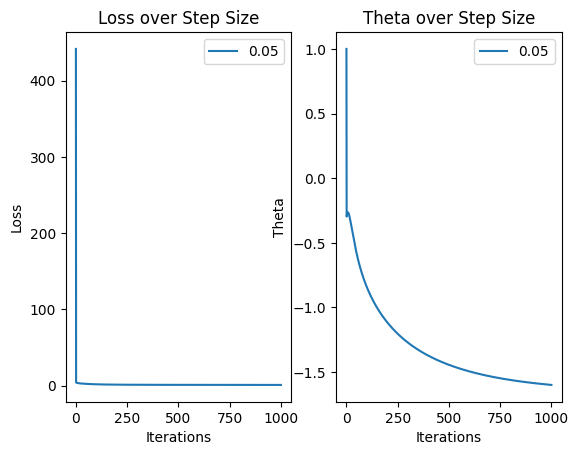

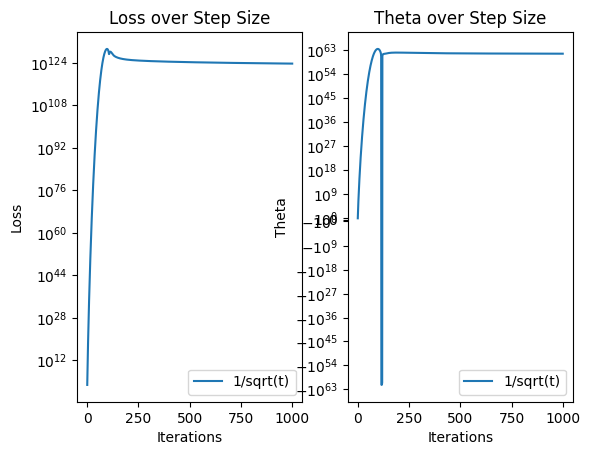

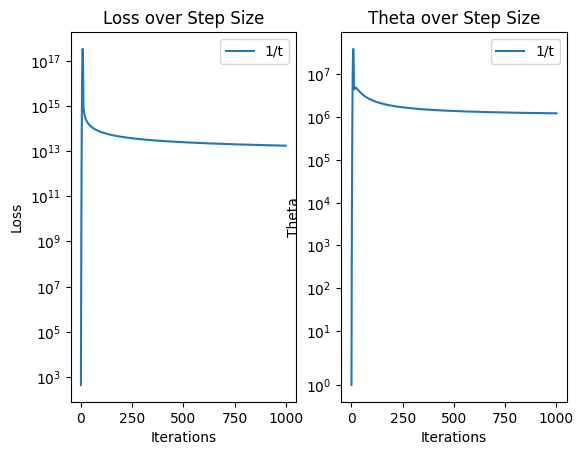

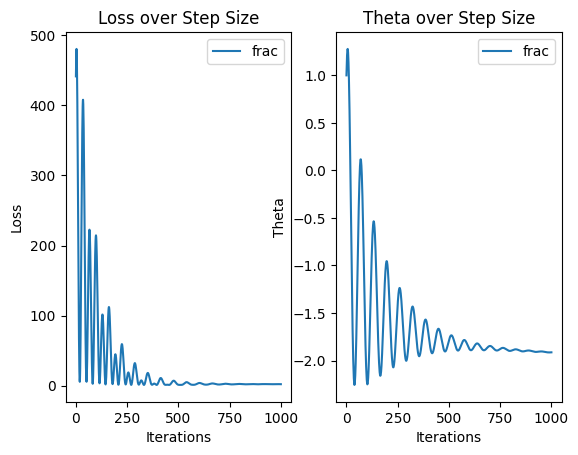

In [72]:
def visualize_sgd(X, y):
    num_iter = 1000
    for step_size in [0.05, "1/sqrt(t)", "1/t", "frac"]:
        theta_hist, loss_hist = stochastic_grad_descent(X, y, step_size,
                                                        lambda_reg=1e-5, num_iter=num_iter)
        draw(theta_hist, loss_hist, step_size, num_iter)
        
visualize_sgd(X_train, y_train)

# Compare Full Batch and SGD
SGD converge a little quickly with comparing of iteration times. But Full Batch can adapt more large step size.

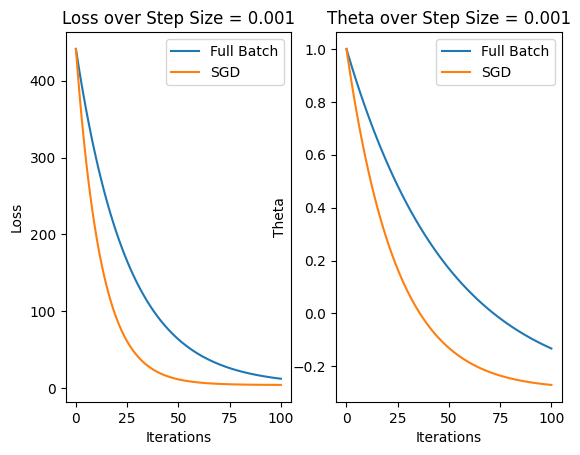

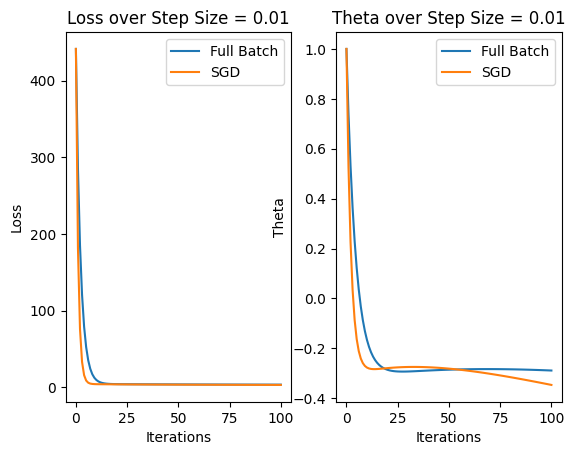

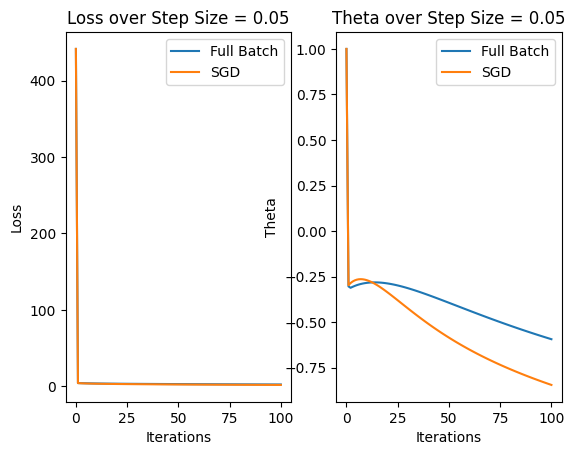

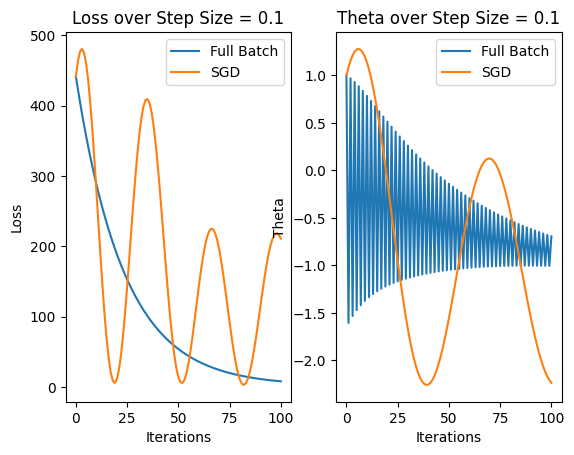

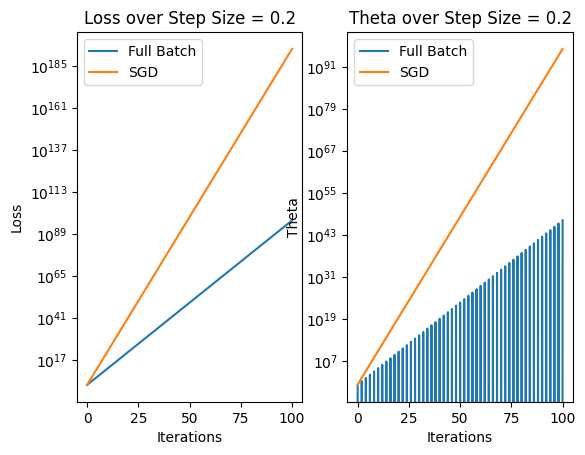

In [75]:
def visualize_compare_batch_and_sgd(X, y):
    num_iter = 100
    for step_size in [0.001, 0.01, 0.05, 0.1, 0.2]:
        theta_hist_batch, loss_hit_batch = batch_grad_descent(X, y, step_size, num_iter)
        theta_hist_sgd, loss_hit_sgd = stochastic_grad_descent(X, y,
                                                               step_size=step_size,
                                                               num_iter=num_iter,
                                                               lambda_reg=1e-4)
        plt.subplot(1, 2, 1)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Loss over Step Size = {0}'.format(step_size))
        plt.plot(loss_hit_batch, label="Full Batch")
        plt.plot(loss_hit_sgd, label="SGD")
        if loss_hit_batch[-1] > 1000:
            plt.yscale('log')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.xlabel('Iterations')
        plt.ylabel('Theta')
        plt.title('Theta over Step Size = {0}'.format(step_size))
        plt.plot(theta_hist_batch.transpose()[0], label="Full Batch")
        plt.plot(theta_hist_sgd.transpose()[0], label="SGD")
        if loss_hit_batch[-1] > 1000:
            plt.yscale('log')
        plt.legend()
        plt.show()
        
visualize_compare_batch_and_sgd(X_train, y_train)

# Risk Minimization Analyse
1. show that for square loss $\mathcal{L}(\hat{y},y)=\frac{1}{2}(y-\hat{y}^{2})$ , its Bayes decision func is $f^{*}(X)=E[Y|X=x]$  
Risk Func $R(f)=\frac{1}{2}E[(f(x)-\hat{y})^{2}]=\frac{1}{2}E[y-\hat{y}^{2}|X=x]=\frac{1}{2}E[(y^{2}-2y\hat{y}+\hat{y}^{2})|X=x]=\frac{1}{2}E[y^{2}|X=x]-E[y\hat{y}|X=x]+\frac{1}{2}E[\hat{y}^{2}]$  
Therefore, $\frac{\partial R(f)}{\partial y}=E[y|X=x]-\hat{y}$   
To minimize $R(f)$, we get $f^{*}(X)=\hat{y}=E[Y|X=x]$  
2. show that for square loss $\mathcal{L}(\hat{y},y)=|y-\hat{y}|$ , its Bayes decision func is $f^{*}(X)=median\ [Y|X=x]$  
Too hard, too many math!  
Can reference: https://github.com/kinslyzhu/DS-GA-1003-ML/blob/master/assignment/hw1-sgd/yz3079_hw1.ipynb